In [1]:
DATASET="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000-012.root"

In [2]:
import time
import os
from mu2etools import *
from mu2etools import wideband
hep.style.use('ATLAS')  # or ATLAS/LHCb2

In [3]:
processor = wideband.DataProcessor(usexroot=True, treename='run', runlist=[1738], userunlist=False, remove=False)
filelist = processor.getFilelist(DATASET)
#append "run" at the end of each file name
filelist = ["{}{}".format(i, ":run") for i in filelist]

In [7]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np_spillNumber = np.array([], dtype=int)
np_eventNumber = np.array([], dtype=int)
np_runNumber = np.array([], dtype=int)
np_subRunNumber = np.array([], dtype=int)
np_nTestLayers = np.array([], dtype=int)
np_totPEsAll = np.array([], dtype=float)

np_trackPEs = np.array([], dtype=int)
np_trackPoints = np.array([], dtype=int)
np_trackChi2 = np.array([], dtype=float)
np_trackIntercept = np.array([], dtype=float)
np_trackSlope = np.array([], dtype=float)
np_totPEsFilt = np.array([], dtype=float)
np_PEsLayer = np.empty((0, 4))


for filename in filelist:
    file = uproot.open(filename)
    for ar in file.iterate(step_size="100MB", 
                                   filter_name=['PEs', 'timeSinceSpill', 
                                                'spillNumber', 'eventNumber', 
                                                'runNumber', 'subrunNumber', 'subrunNumber',
                                                'trackPEs', 'trackPoints', 'trackChi2', 'trackIntercept', 'trackSlope'], 
                                   report=False, library='ak'):
        print(ar)
        # Set PEs to zero for aging counters and quad-counters
        ak.to_numpy(ar['PEs'])[:,0,0:7] = 0
        ak.to_numpy(ar['PEs'])[:,3,0:7] = 0
        ak.to_numpy(ar['PEs'])[:,7,0:7] = 0
        
        feb_masks = []
        #Fill the list of bool arrays for triggered layers
        for feb in [0,3,4,5,6,7]:
            feb_mask = ak.sum(ar['PEs'][:, feb, 4:28], axis=-1) > 10
            feb_masks.append(feb_mask)
            feb_mask = ak.sum(ar['PEs'][:, feb, 36:60], axis=-1) > 10            
            feb_masks.append(feb_mask)
        feb_trig_masks = list(feb_masks[i] for i in range(len(feb_masks))) # Trig layers
        nTrigHits = sum(ak.values_astype(mask, "int") for mask in feb_trig_masks)
        #Get cleaned up array with hits in the triggered layers 
        ar_trig = ar[nTrigHits==12]
        
        totPEsAll = np.sum(ar_trig['PEs'].to_numpy(), axis=(1,2)) # Total PE in the all layers per event
        ar_trig_filt = ak.where(ar_trig['PEs'] >= 5, ar_trig['PEs'], 0)
        totPEsFilt = np.sum(ar_trig_filt.to_numpy(), axis=(1,2)) # Total PE in the all layers per event above 5 PEs
        
        feb_masks = []
        for feb in [1,2]:
            feb_mask = ak.sum(ar_trig_filt[:, feb, 0:31], axis=-1) > 10
            feb_masks.append(feb_mask)
            feb_mask = ak.sum(ar_trig_filt[:, feb, 32:63], axis=-1) > 10
            feb_masks.append(feb_mask)
        feb_trig_masks = list(feb_masks[i] for i in range(len(feb_masks))) # Trig layers
        nTestHits = sum(ak.values_astype(mask, "int") for mask in feb_trig_masks)
        
        pe0 = np.sum(ar_trig_filt[:,1,0:31].to_numpy(), axis=1)
        pe1 = np.sum(ar_trig_filt[:,1,32:63].to_numpy(), axis=1)
        pe2 = np.sum(ar_trig_filt[:,2,0:31].to_numpy(), axis=1)
        pe3 = np.sum(ar_trig_filt[:,2,32:63].to_numpy(), axis=1)
        
        PEsLayer = np.stack([pe0, pe1, pe2, pe3], axis=-1)
        sorted_indices = PEsLayer.argsort()
        PEsLayer = np.take_along_axis(PEsLayer, sorted_indices, axis=-1)
        
        np_spillNumber = np.append(np_spillNumber, ar_trig['spillNumber'].to_numpy())
        np_eventNumber = np.append(np_eventNumber, ar_trig['eventNumber'].to_numpy())
        np_runNumber = np.append(np_runNumber, ar_trig['runNumber'].to_numpy())
        np_subRunNumber = np.append(np_subRunNumber, ar_trig['subrunNumber'].to_numpy())

        np_trackPEs = np.append(np_trackPEs, ar_trig['trackPEs'].to_numpy())
        np_trackPoints = np.append(np_trackPoints, ar_trig['trackPoints'].to_numpy())
        np_trackChi2 = np.append(np_trackChi2, ar_trig['trackChi2'].to_numpy())
        np_trackIntercept = np.append(np_trackIntercept, ar_trig['trackIntercept'].to_numpy())
        np_trackSlope = np.append(np_trackSlope, ar_trig['trackSlope'].to_numpy())
        
        np_nTestLayers = np.append(np_nTestLayers, nTestHits.to_numpy())
        np_totPEsAll = np.append(np_totPEsAll, totPEsAll)
        np_totPEsFilt = np.append(np_totPEsFilt, totPEsFilt)
        np_PEsLayer = np.vstack([np_PEsLayer, PEsLayer])

[{runNumber: 1720, subrunNumber: 0, spillNumber: 1, ... trackPEs: 1.94e+03}]
[{runNumber: 1721, subrunNumber: 0, spillNumber: 1, ... trackPEs: 1.92e+03}]
[{runNumber: 1721, subrunNumber: 1, spillNumber: 515, ... trackPEs: 2.02e+03}]
[{runNumber: 1722, subrunNumber: 0, spillNumber: 1, ... trackPEs: 2.07e+03}]
[{runNumber: 1723, subrunNumber: 0, spillNumber: 1, ... trackPEs: 1.3e+03}]
[{runNumber: 1724, subrunNumber: 0, spillNumber: 1, ... trackPEs: 2.02e+03}]
[{runNumber: 1724, subrunNumber: 1, spillNumber: 621, ... trackPEs: 1.1e+03}]
[{runNumber: 1724, subrunNumber: 2, spillNumber: 1240, ... trackPEs: 2.32e+03}]
[{runNumber: 1727, subrunNumber: 0, spillNumber: 1, ... trackPEs: 1.8e+03}]
[{runNumber: 1728, subrunNumber: 0, spillNumber: 1, ... trackPEs: 2.16e+03}]
[{runNumber: 1728, subrunNumber: 1, spillNumber: 489, ... trackPEs: 1.98e+03}]
[{runNumber: 1729, subrunNumber: 0, spillNumber: 1, ... trackPEs: 1.81e+03}]
[{runNumber: 1729, subrunNumber: 1, spillNumber: 541, ... trackPEs: 2.

In [8]:
df_pe = pd.DataFrame(np_PEsLayer, columns=['pe0', 'pe1', 'pe2', 'pe3'])

In [9]:
# Create a DataFrame
data = {'runNumber': np_runNumber, 
        'subRunNumber': np_subRunNumber,
        'spillNumber': np_spillNumber,
        'eventNumber': np_eventNumber, 
        'totPEsAll': np_totPEsAll,
        'totPEsFilt': np_totPEsFilt,
        'trackPEs': np_trackPEs,
        'trackPoints': np_trackPoints,        
        'nTestLayers': np_nTestLayers,
        'trackChi2': np_trackChi2,
        'trackIntercept': np_trackIntercept,
        'trackSlope': np_trackSlope,
       }
df = pd.DataFrame(data)

In [10]:
df = pd.concat([df, df_pe], axis=1)

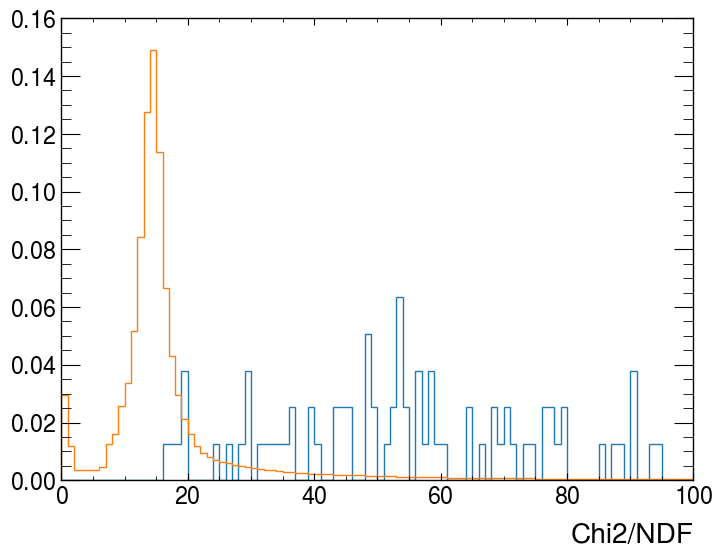

In [11]:
df_ = df.query('nTestLayers<3')
plt.hist(df_['trackChi2']/(df_['trackPoints']-2), histtype='step', density=True, range=(0, 100), bins=100);
df_ = df.query('nTestLayers==4')
plt.hist(df_['trackChi2']/(df_['trackPoints']-2), histtype='step', density=True, range=(0, 100), bins=100);
plt.xlabel("Chi2/NDF");

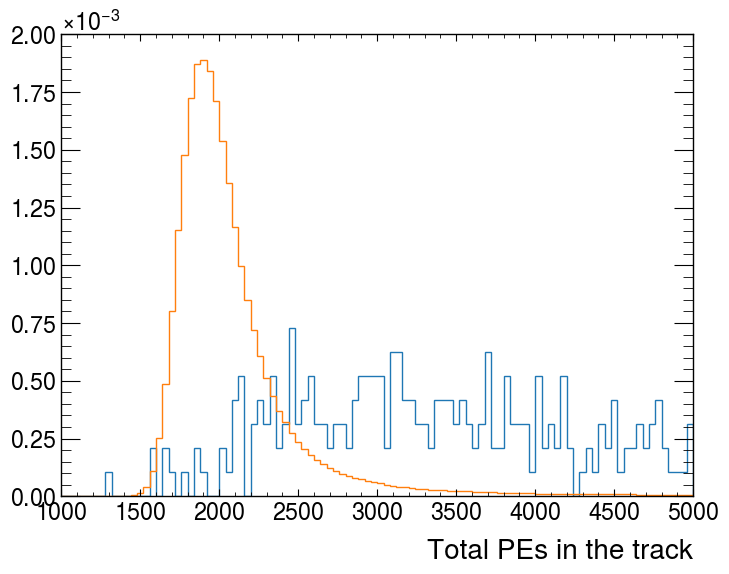

In [12]:
df_ = df.query('nTestLayers<3')
plt.hist(df_['trackPEs'], histtype='step', density=True, range=(1000, 5000), bins=100);
df_ = df.query('nTestLayers==4')
plt.hist(df_['trackPEs'], histtype='step', density=True, range=(1000, 5000), bins=100);
plt.xlabel("Total PEs in the track");

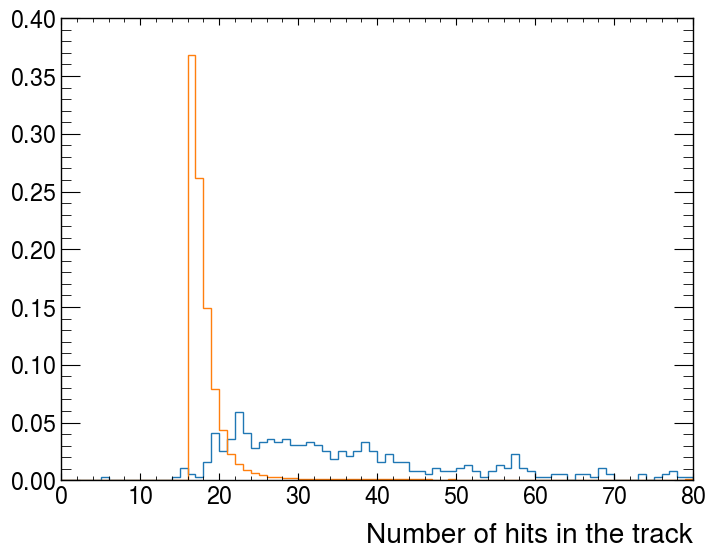

In [13]:
df_ = df.query('nTestLayers<3')
plt.hist(df_['trackPoints'], histtype='step', density=True, range=(0, 80), bins=80);
df_ = df.query('nTestLayers==4')
plt.hist(df_['trackPoints'], histtype='step', density=True, range=(0, 80), bins=80);
plt.xlabel("Number of hits in the track");

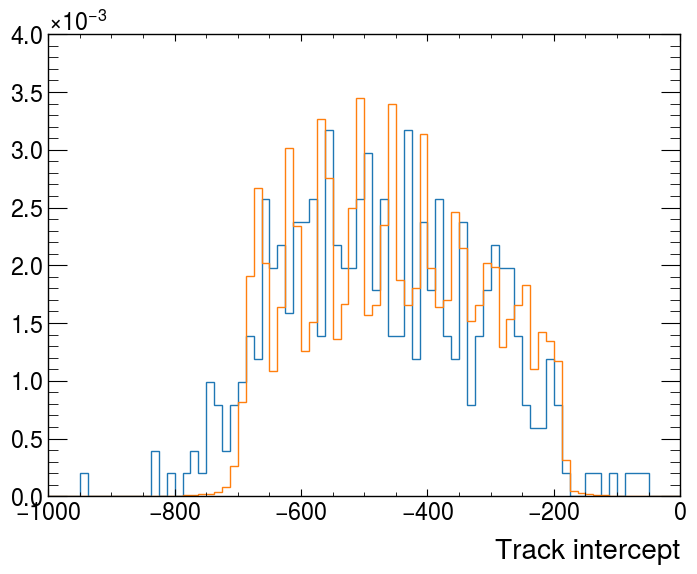

In [14]:
df_ = df.query('nTestLayers<3')
plt.hist(df_['trackIntercept'], histtype='step', density=True, range=(-1000, 0), bins=80);
df_ = df.query('nTestLayers==4')
plt.hist(df_['trackIntercept'], histtype='step', density=True, range=(-1000, 0), bins=80);
plt.xlabel("Track intercept");

In [15]:
cuts = 'trackChi2/(trackPoints-2)<30 & trackPoints < 30 & trackIntercept < -200 & trackIntercept > -700 & trackPEs < 3000'
cuts_ = 'nTestLayers<3 &' + cuts
df.query(cuts_)

,runNumber,subRunNumber,spillNumber,eventNumber,totPEsAll,totPEsFilt,trackPEs,trackPoints,nTestLayers,trackChi2,trackIntercept,trackSlope,pe0,pe1,pe2,pe3
126255,1721,1,853,199,2635.518066,2556.066389,2630.453857,19,1,491.832092,-505.085693,0.042749,0.0,0.000000,0.000000,200.765015
529494,1729,0,140,17,2905.014160,2798.017517,2921.158447,22,2,395.645355,-479.072723,-0.180795,0.0,6.137287,122.124626,244.463886
789783,1730,1,862,385,3179.174561,3085.990848,2921.938965,27,2,740.605408,-524.807434,-0.267114,0.0,5.970828,24.241718,336.493683
843373,1731,0,311,203,2150.536865,2082.955401,2134.322754,16,2,344.605164,-294.107910,-0.069082,0.0,0.000000,122.342098,149.427704
1105146,1738,0,90,106,2430.392578,2335.359870,2410.300049,22,2,383.144714,-398.591675,-0.015430,0.0,6.667589,13.083067,149.607141
1206375,1738,2,1131,275,1664.688232,1587.615811,1564.383545,19,1,279.417267,-426.385559,-0.037259,0.0,0.000000,0.000000,72.300967


In [16]:
cuts_ = 'nTestLayers>=3 &' + cuts
len(df.query(cuts_))

1119376

In [17]:
eff = len(df.query('nTestLayers<3 &' + cuts))/len(df.query(cuts))
print("Efficiency at 10 PE: %.2e"%eff)

Efficiency at 10 PE: 5.36e-06


In [19]:
df.query('pe1<10 &'+cuts)

,runNumber,subRunNumber,spillNumber,eventNumber,totPEsAll,totPEsFilt,trackPEs,trackPoints,nTestLayers,trackChi2,trackIntercept,trackSlope,pe0,pe1,pe2,pe3
126255,1721,1,853,199,2635.518066,2556.066389,2630.453857,19,1,491.832092,-505.085693,0.042749,0.0,0.000000,0.000000,200.765015
529494,1729,0,140,17,2905.014160,2798.017517,2921.158447,22,2,395.645355,-479.072723,-0.180795,0.0,6.137287,122.124626,244.463886
789783,1730,1,862,385,3179.174561,3085.990848,2921.938965,27,2,740.605408,-524.807434,-0.267114,0.0,5.970828,24.241718,336.493683
843373,1731,0,311,203,2150.536865,2082.955401,2134.322754,16,2,344.605164,-294.107910,-0.069082,0.0,0.000000,122.342098,149.427704
1105146,1738,0,90,106,2430.392578,2335.359870,2410.300049,22,2,383.144714,-398.591675,-0.015430,0.0,6.667589,13.083067,149.607141
1206375,1738,2,1131,275,1664.688232,1587.615811,1564.383545,19,1,279.417267,-426.385559,-0.037259,0.0,0.000000,0.000000,72.300967


1119382


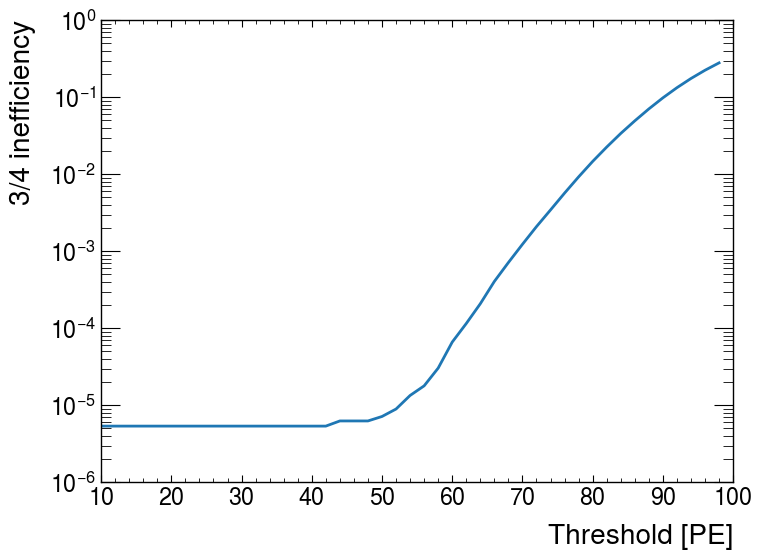

In [25]:
pe1 = df.query(cuts)['pe1'].to_numpy()
print(len(pe1))

threshold_range = range(10, 100, 2)
counts = []
# Loop through each threshold and count elements above it
for threshold in threshold_range:
    mask = pe1 > threshold
    count_above_threshold = np.sum(mask)
    counts.append(count_above_threshold)

plt.plot(threshold_range, 1-np.array(counts)/len(pe1), '-')
plt.xlabel('Threshold [PE]')
plt.ylabel('3/4 inefficiency')
plt.yscale('log')